In [1]:
import xarray as xr
import numpy as np
import seaborn as sns
import datetime
import yaml

import colorcet as cc
import pathlib

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from   matplotlib.offsetbox import AnchoredText

import cartopy as cp
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from   cartopy.feature import LAND
from   cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from   mpl_toolkits.axes_grid1.inset_locator import inset_axes
from   mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
#
# Graphical choices
#
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams["legend.frameon"] = False

# color map for things coded by flight date 
# Gijs used samples from a continuous palette which gives a nice sense of time... 
flight_cols = cc.glasbey_dark 

saveFigs = True

In [3]:
def set_up_map(plt, lon_w = -60.5, lon_e = -49, lat_s = 10, lat_n = 16.5):
    ax  = plt.axes(projection=ccrs.PlateCarree())
    # Defining boundaries of the plot
    
    ax.set_extent([lon_w,lon_e,lat_s,lat_n]) # lon west, lon east, lat south, lat north
    ax.coastlines(resolution='10m',linewidth=1.5,zorder=1);
    ax.add_feature(LAND,facecolor='0.9')
    return(ax)


def add_gridlines(ax):
    # Assigning axes ticks
    xticks = np.arange(-65,0,2.5)
    yticks = np.arange(0,25,2.5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='black', alpha=0.5, linestyle='dotted')
    gl.xlocator = mticker.FixedLocator(xticks)
    gl.ylocator = mticker.FixedLocator(yticks)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}
    gl.ylabels_right = False
    gl.xlabels_bottom = False
    gl.xlabel = {'Latitude'}


### Directories

In [4]:
dataDir = pathlib.Path('/Users/robert/Dropbox/Scientific/Projects/ATOMIC:EURECA4/data')
psl_server = 'http://psl.noaa.gov/thredds/dodsC/Datasets/ATOMIC/data/p3/'
figDir = pathlib.Path('.')

### Flight level data

In [5]:
#
# Can I get the list of dates automatically? Until then... 
#
dates = ['2020-01-17', '2020-01-19', '2020-01-23', 
         '2020-01-24', '2020-01-31', 
         '2020-02-03', '2020-02-04', '2020-02-05', 
         '2020-02-09', '2020-02-10', '2020-02-11']

In [6]:
#
# Flight level data 
#
flight_level_data = xr.open_mfdataset(sorted(dataDir.joinpath('Flight-level/Level_2').glob("*.nc")), 
                                      combine = "by_coords")


### Flight track, plan view 

/Users/robert/anaconda/envs/pangeo2/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


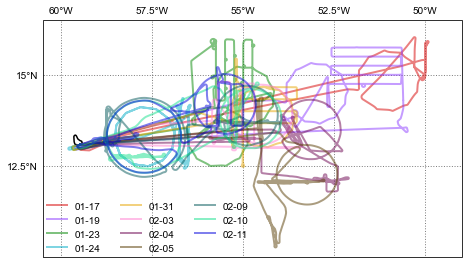

In [7]:
sns.set_context("paper")
fig = plt.figure(figsize = (7.5,8.5))

ax  = set_up_map(plt)
add_gridlines(ax)

if False: ax.annotate("Trade-wind Alley",
            xy=(-56, 13.6),
            size=16, va="top", ha="left",zorder=10
           )

for d in range(len(dates)):
    flight = flight_level_data.sel(time=dates[d])
    ax.plot(flight.lon,flight.lat,lw=2,alpha=0.5,c=flight_cols[d],transform=ccrs.PlateCarree(),zorder=7, label=dates[d][5:])

plt.legend(ncol=3,loc=(0.0,0.0),fontsize=10,framealpha=0.8,markerscale=5)
fig.tight_layout()
if saveFigs: 
    fig.savefig(figDir.joinpath("Flight-track-plan-view.pdf"), dpi=600, transparent=True, bbox_inches = "tight")
    fig.savefig(figDir.joinpath("Flight-track-plan-view.png"), dpi=150, transparent=True, bbox_inches = "tight")

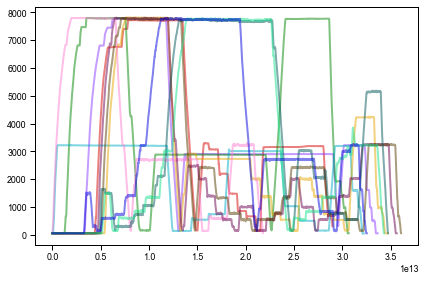

In [8]:
sns.set_context("paper")
#fig = plt.figure(figsize = (7.5,8.5))
#ax = fig.axes

for d in range(len(dates)):
    flight = flight_level_data.sel(time=dates[d])
    flight = flight.where(flight.alt > 0, drop=True)
    plt.plot((flight.time - flight.time.min()).astype('timedelta64[s]'),flight.alt,lw=2,alpha=0.5,c=flight_cols[d], label=dates[d][5:])

plt.tight_layout()
if saveFigs: 
    fig.savefig(figDir.joinpath("Flight-track-side-view.pdf"), dpi=600, transparent=True, bbox_inches = "tight")
    fig.savefig(figDir.joinpath("Flight-track-side-view.png"), dpi=150, transparent=True, bbox_inches = "tight")

## Location of Dropsondes

In [9]:
joanne_l3 = xr.open_dataset(dataDir.joinpath('JOANNE/Level_3/EUREC4A_JOANNE_Dropsonde-RD41_Level_3_v0.5.7-alpha+0.g45fe69d.dirty.nc'))
joanne_l3_p3 = joanne_l3.where(joanne_l3.Platform=='P3', drop='True').swap_dims({"sounding":"launch_time"})

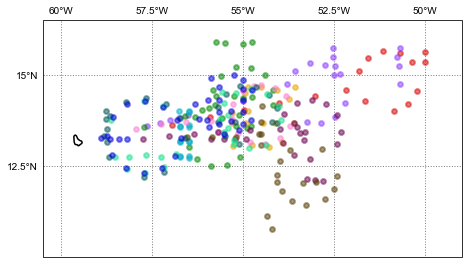

In [10]:
sns.set_context("paper")
fig = plt.figure(figsize = (7.5,8.5))

ax  = set_up_map(plt)
add_gridlines(ax)

for d in range(len(dates)):
    flight = joanne_l3_p3.sel(launch_time = dates[d])
    ax.scatter(flight.flight_lon, flight.flight_lat,
               lw=2,alpha=0.5,c=flight_cols[d],
               transform=ccrs.PlateCarree(),zorder=7,
               label=dates[d][5:])

if saveFigs: 
    fig.savefig(figDir.joinpath("Dropsondes-plan-view.pdf"), dpi=600, transparent=True, bbox_inches = "tight")
    fig.savefig(figDir.joinpath("Dropsondes-plan-view.png"), dpi=150, transparent=True, bbox_inches = "tight")

## Locations of AXBTs (dropsondes TK?)

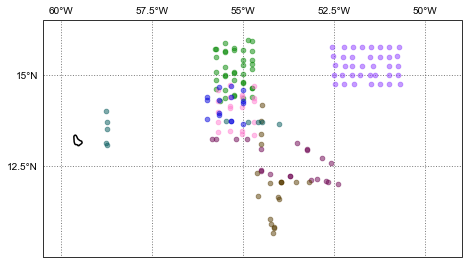

In [11]:
sns.set_context("paper")
fig = plt.figure(figsize = (7.5,8.5))

ax  = set_up_map(plt)
add_gridlines(ax)
#
# Look, ma, I'm using the file from the PSL server! 
#
axbts =  xr.open_dataset(psl_server + 'AXBT/Level_3/P3_AXBT_Level_3_v0.7.nc')

for d in range(len(dates)):
    # Were AXBTs dropped on this day? Seems like there should be an easier way to determine this
    if np.any((axbts.time.values.astype('datetime64[D]') - np.datetime64(dates[d], 'D')) == np.timedelta64(0, 'D')):
        flight = axbts.sel(time=dates[d])
        ax.scatter(flight.lon,flight.lat,alpha=0.5,c=flight_cols[d],transform=ccrs.PlateCarree(),zorder=7, label=dates[d][5:])

#
# Add context for the AXBTs? RHB is already in the text. SWIFT buoys? 
#
if saveFigs: 
    fig.savefig(figDir.joinpath("AXBTs-plan-view.pdf"), dpi=600, transparent=True, bbox_inches = "tight")
    fig.savefig(figDir.joinpath("AXBTs-plan-view.png"), dpi=150, transparent=True, bbox_inches = "tight")

## WSRA figure 

In [12]:
wsra_example = xr.open_dataset(dataDir.joinpath('WSRA/P3_WSRA_20200119_v0.9.nc')).sel(trajectory=slice(0,293))

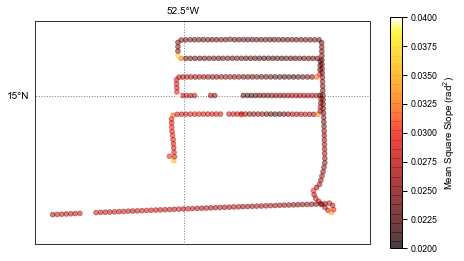

In [13]:
sns.set_context("paper")
fig = plt.figure(figsize = (7.5,8.5))
ax  = set_up_map(plt, lon_e=-50, lon_w=-54.5, lat_s = 13, lat_n = 16)
add_gridlines(ax)

pts = ax.scatter(wsra_example.longitude,wsra_example.latitude,
           c=wsra_example.sea_surface_mean_square_slope_median,
           vmin = 0.02, vmax=0.04,
           cmap=cc.cm.fire,
           alpha=0.5,
           transform=ccrs.PlateCarree(),zorder=7)

fig.colorbar(pts, ax=ax, shrink=0.5, label="Mean Square Slope (rad$^2$)")
if saveFigs: 
    fig.savefig(figDir.joinpath("WSRA-mean-square-slope.pdf"), dpi=600, transparent=True, bbox_inches = "tight")
    fig.savefig(figDir.joinpath("WSRA-mean-square-slope.png"), dpi=600, transparent=True, bbox_inches = "tight")

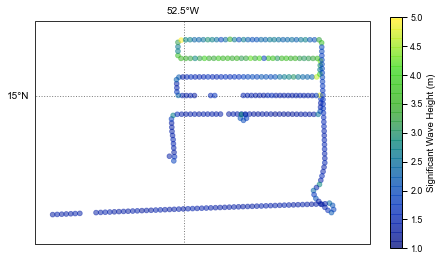

In [14]:
sns.set_context("paper")
fig = plt.figure(figsize = (7.5,8.5))

ax  = set_up_map(plt, lon_e=-50, lon_w=-54.5, lat_s = 13, lat_n = 16)
add_gridlines(ax)

pts = ax.scatter(wsra_example.longitude,wsra_example.latitude,
           c=wsra_example.sea_surface_wave_significant_height,
           vmin = 1, vmax=5,
           cmap=cc.cm.bgy,
           alpha=0.5,
           transform=ccrs.PlateCarree(),zorder=7)

fig.colorbar(pts, ax=ax, shrink=0.5, label="Significant Wave Height (m)")
if saveFigs: 
    fig.savefig(figDir.joinpath("WSRA-significant-wave-height.pdf"), dpi=600, transparent=True, bbox_inches = "tight")
    fig.savefig(figDir.joinpath("WSRA-significant-wave-height.png"), dpi=150, transparent=True, bbox_inches = "tight")

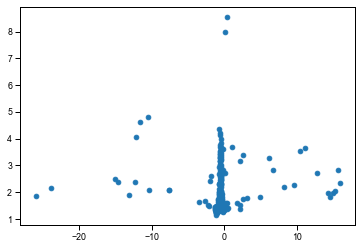

In [26]:
# Outlier values to get the colormaps to look nice are determined here
plt.scatter(wsra_example.wsra_computed_roll.mean(dim="obs"), wsra_example.sea_surface_wave_significant_height)

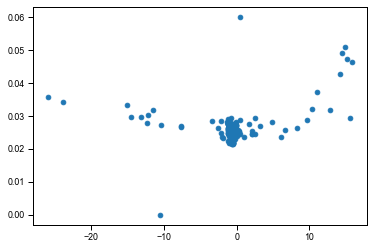

In [27]:
plt.scatter(wsra_example.wsra_computed_roll.mean(dim="obs"), wsra_example.sea_surface_mean_square_slope_median)

In [28]:
wsra_example.close()

## Remote sensing - clouds

In [15]:
cloud_example = xr.open_dataset(dataDir.joinpath('Remote-Sensing/Level_3/P3_Remote-sensing_20200119_v0.5.2.nc'))
subset = cloud_example.sel(time=slice(datetime.datetime(2020, 1, 19, hour=18), 
                                      datetime.datetime(2020, 1, 19, hour=19)))
subset

<xarray.Dataset>
Dimensions:        (time: 7604)
Coordinates:
  * time           (time) datetime64[ns] 2020-01-19T18:00:00.441406250 ... 20...
Data variables:
    lat            (time) float32 ...
    lon            (time) float32 ...
    alt            (time) float32 ...
    pitch          (time) float32 ...
    roll           (time) float32 ...
    tas            (time) float32 ...
    press          (time) float32 ...
    sst_raw        (time) float32 ...
    sst_IR         (time) float32 ...
    cind_radar     (time) float32 ...
    cind_IR        (time) float32 ...
    T_IR_CT        (time) float32 ...
    T_Air_CT       (time) float32 ...
    ws_CT          (time) float32 ...
    alt_CT         (time) float32 ...
    Z_CT           (time) float32 ...
    Vd_CT          (time) float32 ...
    Rain_Rate      (time) float32 ...
    CS_Radar_Corr  (time) float32 ...
    MSS_Radar      (time) float32 ...
    U10_SMFR       (time) float32 ...
    U10_SMFR_Corr  (time) float32 ...
Attributes:
    creation_date:  2020-08-04 02:45:02 UTC
    Conventions:    CF-1.7
    campaign:       EUREC4A
    activity:       ATOMIC
    platform:       P3
    product:        Remote-sensing
    contact:        Chris Fairall <Chris.Fairall@noaa.gov>
    version:        v0.5.2

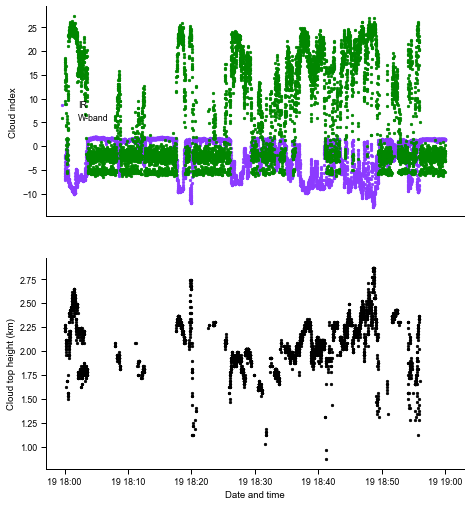

In [18]:
sns.set_context("paper")
fig = plt.figure(figsize = (7.5,8.5))
ax1, ax2 = fig.subplots(2, sharex=True)

ax1.scatter(subset.time, subset.cind_IR,    color=cc.glasbey[1], marker = ".", label="IR")
ax1.scatter(subset.time, subset.cind_radar, color=cc.glasbey[2], marker = ".", label="W-band")
ax1.legend()
sns.despine(bottom=True)
ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax1.xaxis.set_visible(False)
ax1.set_ylabel("Cloud index")

ax2.scatter(subset.time, subset.alt_CT, color="black", marker = ".")
ax2.set_ylabel("Cloud top height (" + subset.alt_CT.units + ")")
ax2.set_xlabel("Date and time")
sns.despine()

if saveFigs: 
    fig.savefig(figDir.joinpath("Cloud-remote-sensing.pdf"), dpi=600, transparent=True, bbox_inches = "tight")
    fig.savefig(figDir.joinpath("Cloud-remote-sensing.png"), dpi=150, transparent=True, bbox_inches = "tight")

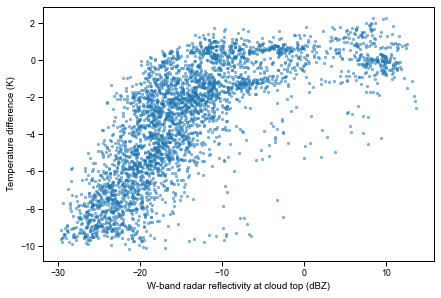

In [48]:
sns.set_context("paper")
fig = plt.figure(figsize = (7,7/1.5))
ax = plt.axes()

ax.scatter(subset.Z_CT, 
            subset.T_Air_CT - cloud_example.T_IR_CT, 
            marker = ".", alpha=0.5) 
ax.set_ylabel("Temperature difference (K)")
ax.set_xlabel("W-band radar reflectivity at cloud top (dBZ)")


if saveFigs: 
    fig.savefig(figDir.joinpath("Reflectivity-vs-Temp-diff.pdf"), dpi=600, transparent=True, bbox_inches = "tight")
    fig.savefig(figDir.joinpath("Reflectivity-vs-Temp-diff.png"), dpi=150, transparent=True, bbox_inches = "tight")

## Radar reflectivity

In [21]:
w_band = xr.open_dataset(dataDir.joinpath('W-band/ATOMIC_P3_W-band_20200119_19UTC.nc')).sel(height = slice(0, 3))

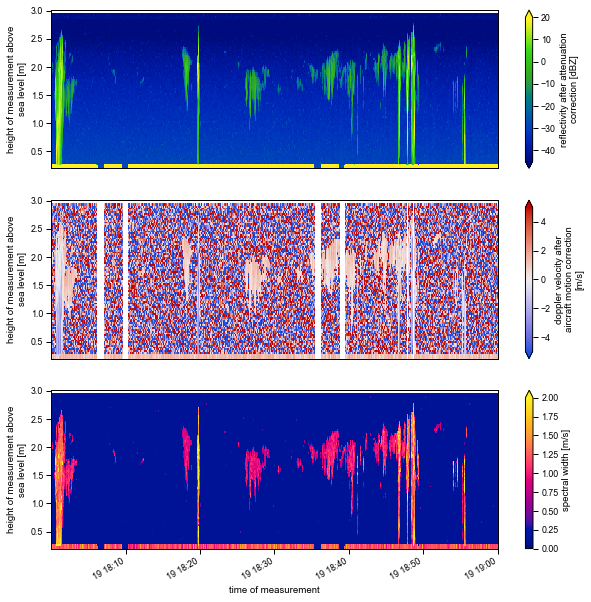

In [22]:
fig = plt.figure(figsize = (10,8.5))
axes = fig.subplots(3, 1, sharex=True)
w_band.corrected_reflectivity.plot(x="time", y="height", 
                                   ax = axes[0], 
                                   vmin = -45, vmax = 20, cmap = cc.m_bgy)
w_band.corrected_dopplervelocity.plot(x="time", y="height", 
                                      ax = axes[1],
                                      vmin = -5, vmax = 5, 
                                      cmap = cc.m_coolwarm)
w_band.spectralwidth.plot(x="time", y="height", 
                          ax = axes[2],
                          vmin = 0, vmax = 2,
                          cmap = cc.m_bmy)

for ax in axes[0:2]: 
    ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
    ax.xaxis.set_visible(False)

fig.subplots_adjust(bottom = 0)

if saveFigs: 
    # fig.savefig(figDir.joinpath("Radar-examples.pdf"), dpi=600, transparent=True, bbox_inches = "tight")
    fig.savefig(figDir.joinpath("Radar-examples.png"), dpi=150, transparent=True, bbox_inches = "tight")

In [22]:
# if saveFigs: fig.savefig(figDir.joinpath("W-band-example.pdf"), dpi=600, transparent=True)

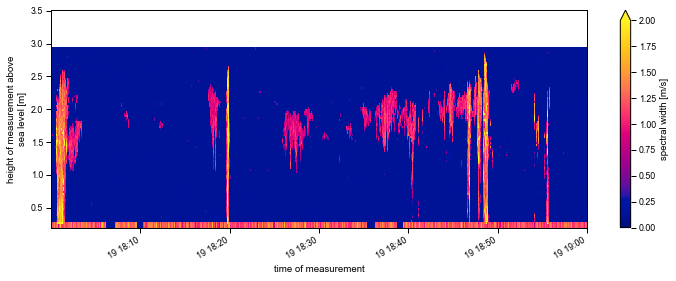

In [38]:
w_band.sel(height = slice(0, 3.5)).spectralwidth.plot(x="time", y="height", 
                                                         size = 4, aspect = 3, 
                                                         vmin = 0, vmax = 2, cmap = cc.m_bmy)

In [39]:
w_band.height.diff(dim="height").min(), w_band.height.diff(dim="height").max()

(<xarray.DataArray 'height' ()>
 array(0.03121901, dtype=float32),
 <xarray.DataArray 'height' ()>
 array(0.03121996, dtype=float32))